In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/initialization')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr_bias import FcIPLLRBias
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.dataset.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.ranks import *
from utils.nn import *

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Load basic configuration and define variables 

In [6]:
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 512
base_lr = 0.1
n_steps = 50
tol = 1.0e-8
activation = 'elu'

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [7]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['activation']['name'] = activation
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': False,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)

### Load data & define model

In [8]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [9]:
full_x = torch.cat([a for a,_ in batches], dim=0)
full_y = torch.cat([b for _,b in batches], dim=0)

## Define model

In [10]:
ipllr_bias = FcIPLLRBias(base_model_config, lr_calibration_batches=batches)

In [11]:
for i, param_group in enumerate(ipllr_bias.optimizer.param_groups):
    if i == 0:
        param_group['lr'] = param_group['lr'] * (ipllr_bias.d + 1)

## Save initial model

In [12]:
ipllr_bias_0 = deepcopy(ipllr_bias)

### Train model one step : t=1

In [13]:
x, y = batches[0]

train_model_one_step(ipllr_bias, x, y, normalize_first=True)
ipllr_bias_1 = deepcopy(ipllr_bias)

input abs mean in training:  0.6950533986091614
loss derivatives for model: tensor([[-0.9842,  0.0612,  0.1481,  ...,  0.1386,  0.2036,  0.0223],
        [ 0.0158, -0.9388,  0.1481,  ...,  0.1386,  0.2036,  0.0223],
        [ 0.0158,  0.0612,  0.1481,  ...,  0.1386,  0.2036, -0.9777],
        ...,
        [ 0.0158,  0.0612,  0.1481,  ...,  0.1386,  0.2036, -0.9777],
        [ 0.0158,  0.0612,  0.1481,  ...,  0.1386,  0.2036,  0.0223],
        [ 0.0158,  0.0612,  0.1481,  ...,  0.1386, -0.7964,  0.0223]])
average training loss for model1 : 2.5332136154174805



### Train model for a second step : t=2

In [14]:
x, y = batches[1]

train_model_one_step(ipllr_bias, x, y, normalize_first=True)
ipllr_bias_2 = deepcopy(ipllr_bias)

input abs mean in training:  0.6921874284744263
loss derivatives for model: tensor([[ 0.0161,  0.0627,  0.1474,  ...,  0.1384, -0.7989,  0.0228],
        [ 0.0161,  0.0627,  0.1474,  ...,  0.1384,  0.2011,  0.0228],
        [ 0.0161,  0.0627,  0.1474,  ...,  0.1384,  0.2011,  0.0228],
        ...,
        [ 0.0161,  0.0627,  0.1474,  ...,  0.1384,  0.2011,  0.0228],
        [ 0.0161, -0.9373,  0.1474,  ...,  0.1384,  0.2011,  0.0228],
        [ 0.0161,  0.0627,  0.1474,  ...,  0.1384, -0.7989,  0.0228]])
average training loss for model1 : 2.591599941253662



In [15]:
ipllr_bias.eval()
ipllr_bias_0.eval()
ipllr_bias_1.eval()
ipllr_bias_2.eval()
print('')

In [16]:
layer_scales = ipllr_bias.layer_scales
intermediate_layer_keys = ["layer_{:,}_intermediate".format(l) for l in range(2, L + 1)]

### Define W0 and b0

In [17]:
W0, b0 = get_W0_b0_dict(ipllr_bias_0, normalize_first=True) 

### Define Delta_W_1 and Delta_b_1

In [18]:
Delta_W_1, Delta_b_1 = get_Delta_W1_b1_dict(ipllr_bias_0, ipllr_bias_1, normalize_first=True)

### Define Delta_W_2 and Delta_b_2

In [19]:
Delta_W_2, Delta_b_2 = get_Delta_W2_b2_dict(ipllr_bias_1, ipllr_bias_2, normalize_first=True)

## Explore at step 1

### On all training samples

In [20]:
x, y = full_x, full_y

In [21]:
h0, delta_h_1, h1, x1 = get_contributions_1_bias(x, ipllr_bias_1, W0, b0, Delta_W_1, Delta_b_1,
                                                 normalize_first=True)

## Ranks after one step

### Rank of the initial weights and first two updates 

In [22]:
weight_ranks_dfs_dict = dict()

tol = None
weight_ranks_dfs_dict['svd_default'] = get_svd_ranks_weights(W0, Delta_W_1, Delta_W_2, L, tol=tol)

tol = 1e-7
weight_ranks_dfs_dict['svd_tol'] = get_svd_ranks_weights(W0, Delta_W_1, Delta_W_2, L, tol=tol)

weight_ranks_dfs_dict['squared_tr'] = get_square_trace_ranks_weights(W0, Delta_W_1, Delta_W_2, L)

In [23]:
weight_ranks_dfs_dict['svd_default']

,layer,W0,Delta_W_1,Delta_W_2,max
layer,,,,,
1,1,784,399,62,784
2,2,1024,72,989,1024
3,3,1024,9,962,1024
4,4,1023,5,135,1024
5,5,1024,1,1,1024
6,6,1024,1,1,1024
7,7,10,1,1,10


In [24]:
weight_ranks_dfs_dict['svd_tol']

,layer,W0,Delta_W_1,Delta_W_2,max
layer,,,,,
1,1,784,528,0,784
2,2,1024,174,0,1024
3,3,1024,9,1,1024
4,4,1024,9,1,1024
5,5,1024,1,1,1024
6,6,1024,1,1,1024
7,7,10,1,1,10


In [25]:
weight_ranks_dfs_dict['squared_tr']

,layer,W0,Delta_W_1,Delta_W_2,max
layer,,,,,
1,1,444.829,3.86184,2.10188e-37,784
2,2,511.408,0.482948,8.4452e-24,1024
3,3,511.481,0.792437,7.48235e-18,1024
4,4,512.71,0.839915,9.93884e-12,1024
5,5,511.697,0.933045,2.202e-05,1024
6,6,511.76,0.960641,0.964487,1024
7,7,9.87399,5.96421e-05,7.18195e-05,10


In [26]:
ranks_dfs = [weight_ranks_dfs_dict['svd_default'],
             weight_ranks_dfs_dict['svd_tol'],
             weight_ranks_dfs_dict['squared_tr']]

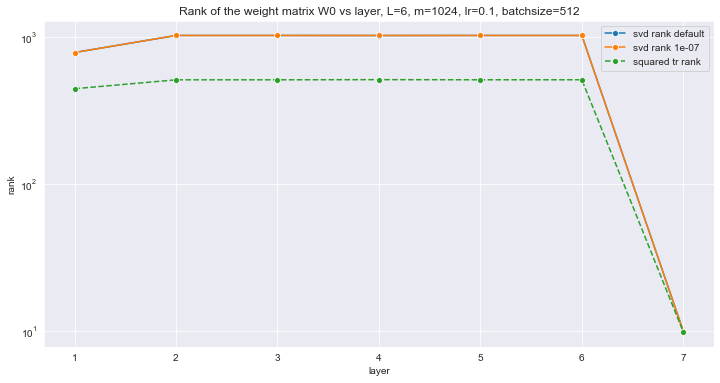

In [27]:
plt.figure(figsize=(12, 6))
plot_weights_ranks_vs_layer('W0', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

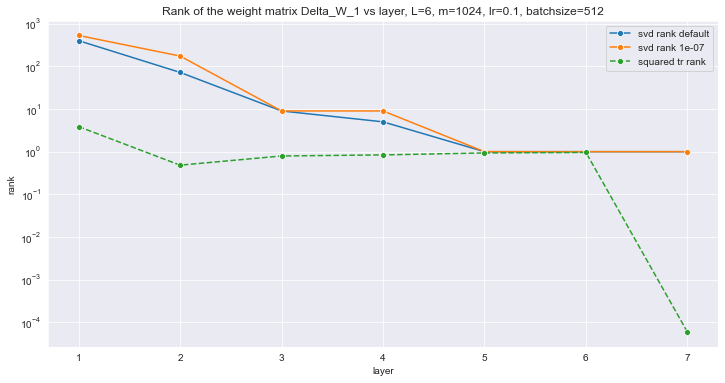

In [28]:
plt.figure(figsize=(12, 6))
plot_weights_ranks_vs_layer('Delta_W_1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

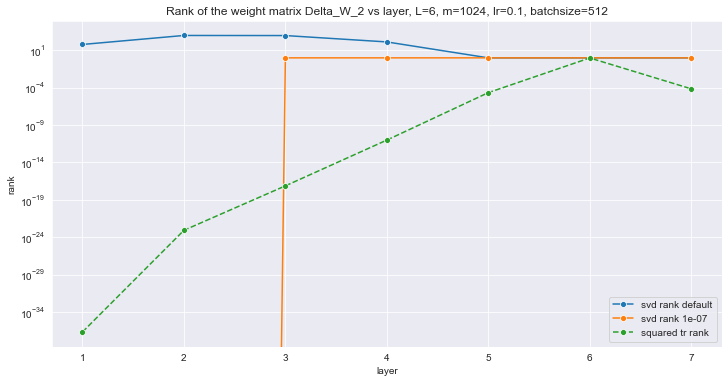

In [29]:
plt.figure(figsize=(12, 6))
plot_weights_ranks_vs_layer('Delta_W_2', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

#### Ranks of the pre-activations

In [30]:
act_ranks_df_dict = dict()

tol = None
act_ranks_df_dict['svd_default'] = get_svd_ranks_acts(h0, delta_h_1, h1, x1, L, tol=tol) 

tol = 1e-7
act_ranks_df_dict['svd_tol'] = get_svd_ranks_acts(h0, delta_h_1, h1, x1, L, tol=tol) 

act_ranks_df_dict['squared_tr'] = get_square_trace_ranks_acts(h0, delta_h_1, h1, x1, L)

In [31]:
act_ranks_df_dict['svd_default']

,layer,h0,delta_h_1,h1,x1,max
layer,,,,,,
1,1,429,13,254,292,1024
2,2,5,9,5,5,1024
3,3,1,1,1,1,1024
4,4,1,1,1,1,1024
5,5,1,1,1,1,1024
6,6,1,1,1,1,1024
7,7,1,1,1,1,10


In [32]:
act_ranks_df_dict['svd_tol']

,layer,h0,delta_h_1,h1,x1,max
layer,,,,,,
1,1,1024,1024,1024,1024,1024
2,2,1024,687,1024,1024,1024
3,3,1024,632,1024,1024,1024
4,4,1024,544,1024,1024,1024
5,5,1024,579,1024,1024,1024
6,6,1024,445,1024,1024,1024
7,7,10,9,10,10,10


In [33]:
act_ranks_df_dict['squared_tr']

,layer,h0,delta_h_1,h1,x1,max
layer,,,,,,
1,1,8.44141,1.39891,2.162,2.17878,1024
2,2,1.00173,1.20049,1.00177,1.00183,1024
3,3,1,1,1,1,1024
4,4,1,1,1,1,1024
5,5,1,1,1,1,1024
6,6,1,1,1,1,1024
7,7,1,1,1,1,10


In [34]:
ranks_dfs = [act_ranks_df_dict['svd_default'],
             act_ranks_df_dict['svd_tol'],
             act_ranks_df_dict['squared_tr']]

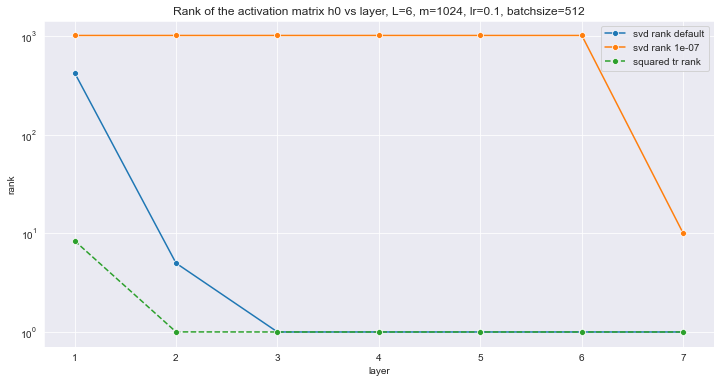

In [35]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('h0', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

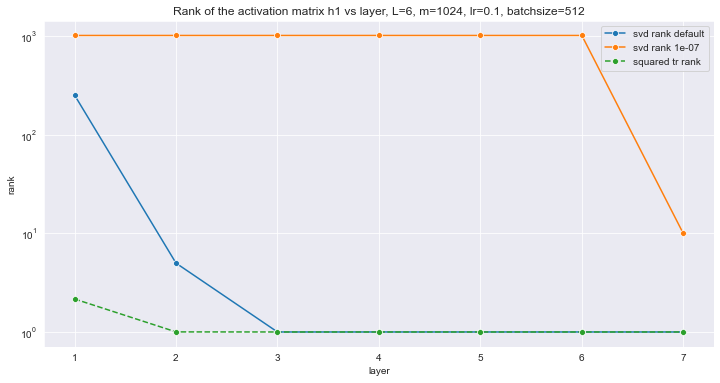

In [36]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('h1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

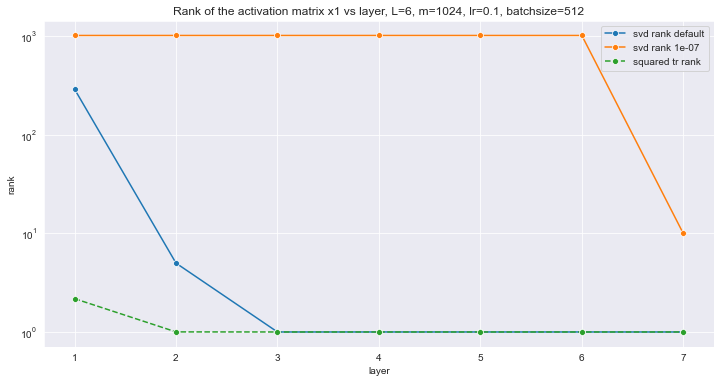

In [37]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('x1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

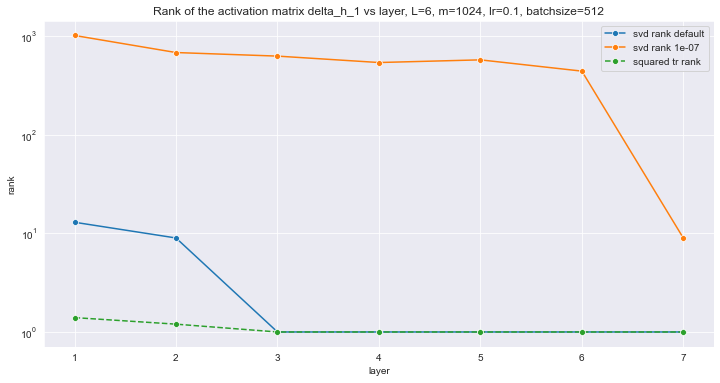

In [38]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('delta_h_1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

### Diversity in terms of position of the maximum index

In [39]:
max_acts_diversity_df = get_max_acts_diversity(h0, delta_h_1, h1, L)

In [40]:
max_acts_diversity_df

,layer,h0,delta_h_1,h1,max
layer,,,,,
1,1,681,39,240,60000
2,2,1,18,1,60000
3,3,1,1,1,60000
4,4,1,1,1,60000
5,5,1,1,1,60000
6,6,1,1,1,60000
7,7,1,1,1,60000
